### **FRAUD DETECTION IN ELECTRICITY AND GAS CONSUMPTION**

An electricity and gas distribution company STEG has suffered huge losses approximately 200 million Tunisian Dinars due to fraudulent manipulation of meters by its customers. We will use the data the company has on the billing history of its customers to detect fradulent activities.

#### **DATA**
* For training and testing, there are two datasets: client data and the clients invoice


**Variable definitions**

Client:

* Client_id: Unique id for client
* District: District where the client is
* Client_catg: Category client belongs to
* Region: Area where the client is
* Creation_date: Date client joined
* Target: fraud:1 , not fraud: 0

Invoice data

* Client_id: Unique id for the client
* Invoice_date: Date of the invoice
* Tarif_type: Type of tax
* Counter_number:
* Counter_statue: takes up to 5 values such as working fine, not working, on * hold statue, ect
* Counter_code:
* Reading_remarque: notes that the STEG agent takes during his visit to the * client (e.g: If the counter shows something wrong, the agent gives a bad score)
*Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
* Consommation_level_1: Consumption_level_1
* Consommation_level_2: Consumption_level_2
* Consommation_level_3: Consumption_level_3
* Consommation_level_4: Consumption_level_4
* Old_index: Old index
* New_index: New index
* Months_number: Month number
*Counter_type: Type of counter


<a id="cont"></a>

## **Table of Contents**

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## **1.Importing Packages**
<a href=#cont>Back to Table of Contents</a>

In [47]:
# Library for Google Colab
from google.colab import drive
from scipy import stats
drive.mount('/content/drive')

# Base Libraries
import re
import time
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np

# Library for visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id="two"></a>
## **2. Loading Data**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [48]:
#load training data
client_train_df = pd.read_csv('/content/drive/MyDrive/Internship/train/client_train.csv') 
invoice_train_df = pd.read_csv('/content/drive/MyDrive/Internship/train/invoice_train.csv') 

#load testing data
client_test_df = pd.read_csv('/content/drive/MyDrive/Internship/test/client_test.csv') 
invoice_test_df = pd.read_csv('/content/drive/MyDrive/Internship/test/invoice_test.csv') 

<a id="three"></a>
## **3. Exploratory Data Analysis (EDA)**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### **Basic Analysis**

Here we we look at:
* The first five data points for each dataset
* The shape of our data: how many columns and rows are in each dataframe
* The data types for each column
* Check if there are null values 

In [49]:
#check the first five datapoints for each set
client_train_df.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [50]:
invoice_train_df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [51]:
#train data
client_train_df.shape

(135493, 6)

In [52]:
#train data
invoice_train_df.shape

(4476749, 16)

In [53]:
#test data
client_test_df.shape

(58069, 5)

In [54]:
#test data
invoice_test_df.shape

(1939730, 16)

**Train data**

The client train dataframe has 135,493 rows and 6 columns while the invoice train dataframe has 4,476,749 rows and 16 columns. 

**Test data**

The client test dataframe has 58,069 rows and 5 columns. This is one less column than the client test dataframe. The invoice test dataframe on the other hand has 1,939,730 rows and 16 columns. 

We will confirm that the missing column in our client test dataframe is the target column. 

In [55]:
#basic info and datatypes 
client_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [56]:
client_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disrict        58069 non-null  int64 
 1   client_id      58069 non-null  object
 2   client_catg    58069 non-null  int64 
 3   region         58069 non-null  int64 
 4   creation_date  58069 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.2+ MB


* We can observe that the missing column from the client **test** dataframe is the **target** column literally. This is the column that our model is supposed to predict. 
* There are two datatypes: int64 and object.
* Our target column is of the data type float64.

In [57]:
client_train_df.nunique()

disrict               4
client_id        135493
client_catg           3
region               25
creation_date      8088
target                2
dtype: int64

In [58]:
invoice_train_df.nunique()

client_id               135493
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

* The number of unique client_id is similar for both datasets. We will therefore map the client dataset onto the invocice data so that we can be able to analyse our dataset with the target column present. 
* From the counter_type column we can observe that there are two types of counters

In [59]:
invoice_train_df['counter_type'].unique()

array(['ELEC', 'GAZ'], dtype=object)

* The types of counter are **ELEC** and **GAZ**. These represent electricity and gas counters repectively.

In [60]:
#merge the two train dataframes
train_df= pd.merge(invoice_train_df, client_train_df, how='inner', on = 'client_id')

In [61]:
#merge the two test dataframes
test_df= pd.merge(invoice_test_df, client_test_df, how='inner', on = 'client_id')

After merging the two dataframes, we expect:
* The number of rows for the new train dataframe to be the same as the number of rows from the invoice train dataframe i.e 4476749
* The number of columns to be a sum of the columns from the two dataframes i.e 21

We can confirm this by using the .shape method below:

In [62]:
#check the shape of the new train dataframe
train_df.shape 

(4476749, 21)

In [63]:
#check the first five rows of our train data
train_df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,...,0,14302,14384,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,...,0,12294,13678,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,...,0,14624,14747,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,...,0,14747,14849,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,...,0,15066,15638,12,ELEC,60,11,101,31/12/1994,0.0


#### **Advanced Analysis**

Here we are going to examine:
* The target column
* Which region had the highest number of fraud cases
* Which district had the highest number of fraud cases
* Which year, month and day recorded the highest number of fraud cases
* Which counter type is more subject to tempering

#### **Examine the target column**

In [64]:
#count unique values
train_df['target'].unique()

array([0., 1.])

There are two classes in our data: 0 and 1

In [65]:
#data amount provided per class
train_df['target'].value_counts()

0.0    4123637
1.0     353112
Name: target, dtype: int64

* This shows the amount of data provided for each class. We can observe that  fraudulent cases (1.0) are significantly less than non-fradulent cases(0.0). This can be better shown in a bar graph:

Text(0.5, 1.0, 'Percentage data for each class')

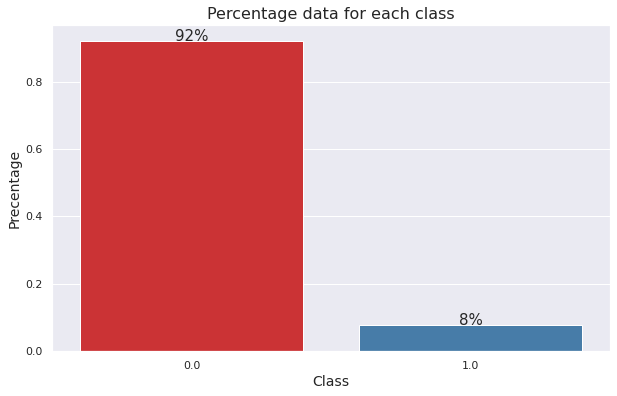

In [66]:
#How many data samples are provided for each class
plt.figure(figsize=(10,6))
g = sns.barplot(train_df['target'], train_df['target'], palette='Set1', estimator=lambda x: len(x) / len(train_df))

for p in g.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    g.text(x+width/2, 
           y+height, 
           '{:.0%}'.format(height), 
           horizontalalignment='center',fontsize=15)
    
#Setting the labels
plt.xlabel('Class', fontsize=14)
plt.ylabel('Precentage', fontsize=14)
plt.title('Percentage data for each class', fontsize=16)



* The bar graph confirms a severe **class imbalance**. 
* **Class imbalance** is where there are very few cases reperesenting a given class.
* This can affect our model's ability to accurately predict fradulent cases because it has seen few such cases. During model evaluation we will asses our model's ability to predict these fradulent cases. If the accuracy is low, then we can upsample our data or find other methods of dealing with class imbalance.


#### **Which region had the highest fraud cases**

In [67]:
#separate fraud cases from non-fradulent cases
fraud = train_df[train_df['target']==1]
non_fraud = train_df[train_df['target']==0]

In [68]:
fraud_region= fraud[['region','target']].groupby('region').count()
nonfraud_region= non_fraud[['region','target']].groupby('region').count()

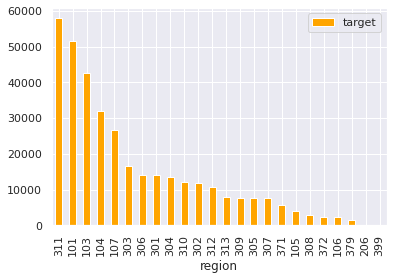

In [69]:
#plot region by fraud cases
fraud_region.sort_values('target', ascending=False).plot(kind='bar', color='orange')
plt.show()

* We will focus on the fraud cases since they are the ones giving the company loses
* Out of 25 regions, region 311 has the highest number of fraud cases followed by 101.

#### **Which district had the highest fraud cases**


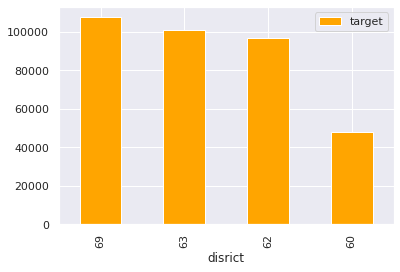

In [70]:
fraud_district= fraud[['disrict','target']].groupby('disrict').count()
#plot region by fraud cases
fraud_district.sort_values('target', ascending=False).plot(kind='bar', color='Orange')
plt.show()

Out of the 4 districts, district 69 has the highest number of fraud cases cases.

#### **Which Year recorded the highest number of fraud cases**

In [75]:
#convert date to a datatype we can use to plot
fraud['time'] = pd.to_datetime(fraud['invoice_date'], format='%Y-%m-%d %H:%M:%S')
#split datetime to year, month, day, hour
fraud['year'] = pd.DatetimeIndex(fraud['time']).year
fraud['month'] = pd.DatetimeIndex(fraud['time']).month
fraud['day'] = pd.DatetimeIndex(fraud['time']).day

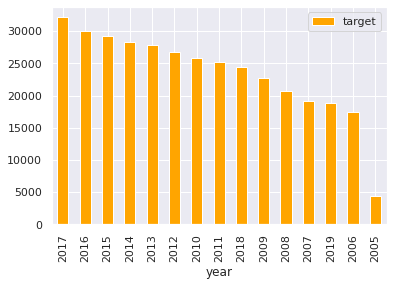

In [76]:
year_df = fraud[['year','target']].groupby('year').count()
#plot region by fraud cases
year_df.sort_values('target', ascending=False).plot(kind='bar', color='Orange')
plt.show()

* Of the data provided for the 15 years, the year 2017 had the highest number of fradulent cases, while 2005 had the least cases.

#### **Which month recorded the highest number of fraud cases**

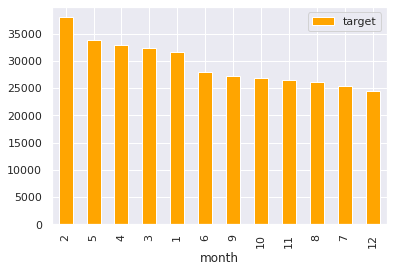

In [79]:
month_df = fraud[['month','target']].groupby('month').count()
#plot region by fraud cases
month_df.sort_values('target', ascending=False).plot(kind='bar', color='Orange')
plt.show()

* The first five months of the year recorded the highest number of fraud cases with february leading the pack.

#### **Which days recorded the highest number of fraud cases**

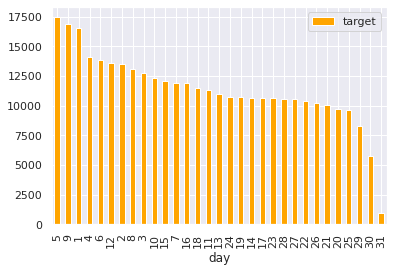

In [81]:
day_df = fraud[['day','target']].groupby('day').count()
#plot region by fraud cases
day_df.sort_values('target', ascending=False).plot(kind='bar', color='Orange')
plt.show()

* During the begining of the month, there are usually more fraud cases than at the end of the month

#### **Which Counter recorded the highest number of fraud cases**

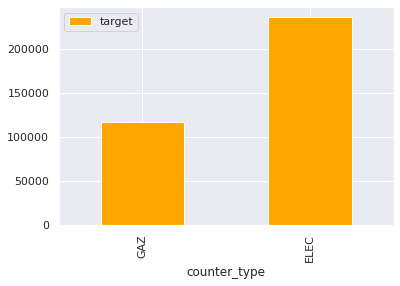

In [82]:
type_df = fraud[['counter_type','target']].groupby('counter_type').count()
#plot region by fraud cases
type_df.sort_values('counter_type', ascending=False).plot(kind='bar', color='Orange')
plt.show()

* Electricity counters are more subject to theft than gas counters